# Demo for the mutual_information module
We check the expected behaviour for mutual information loss (MI loss) and the normalized mutual information loss (NMI)
For two sample data of the same shape X,Y, these are respectively:
- $MI(X,Y)= H(X) + H(Y) - H(X,Y)$
- $NMI(X,Y)= (H(X) + H(Y)) / H(X,Y)$
Where H(X) is the Shannon entropy for X and H(X,Y) is the Shannon entropy for $X\oplus Y$

Observe the two extreme situations:
- if $Y=f(X)$ and $X=g(Y)$ for some functions $f$ and $g$, then $H(X)=H(X,Y)=H(Y)$
- if $X$ and $Y$ are independant, then $H(X,Y)=H(X) + H(Y)$

These are the key observations for the announced output expectations in the loop below.

In [1]:
import torch

from kornia.losses.mutual_information import mutual_information_loss, normalized_mutual_information_loss

/home/gael.cousin/Documents/my_code/kornia/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def relative_mi(img_1,img_2,window_radius):
    """Should theoretically be 0 if img_1 and img_2 are independent and 1 if img_1 = f(img_2), f one to one."""
    numerator = mutual_information_loss(img_1, img_2,window_radius=window_radius)
    denominator = mutual_information_loss(img_2, img_2,window_radius=window_radius)
    return numerator/denominator

In [3]:
n_samples = 10000
num_bins = 64


def sampling_function():
    data = torch.rand(n_samples,dtype=torch.double)
    return 400 * torch.sin(data * torch.pi)



img_1 = sampling_function()
img_2 = 50 * img_1 + 1
img_3 = sampling_function()

for radius in [1/2, 1, 2, 3]:
    print(f"MI, {radius=}, expect 1")
    print(relative_mi(img_1, img_2, window_radius=radius))
    print(f"MI {radius=}, expect 0")
    print(relative_mi(img_1, img_3, window_radius=radius))
    print(relative_mi(img_2, img_3, window_radius=radius))

    print(f'NMI {radius=}, expect -2')
    print(normalized_mutual_information_loss(img_1,img_2,window_radius=radius,num_bins=num_bins))
    print(f'NMI {radius=}, expect -1')
    print(normalized_mutual_information_loss(img_1,img_3,window_radius=radius,num_bins=num_bins))
    print(normalized_mutual_information_loss(img_2,img_3,window_radius=radius,num_bins=num_bins))

MI, radius=0.5, expect 1
tensor(1.0000, dtype=torch.float64)
MI radius=0.5, expect 0
tensor(0.1266, dtype=torch.float64)
tensor(0.1266, dtype=torch.float64)
NMI radius=0.5, expect -2
tensor(-2.0000, dtype=torch.float64)
NMI radius=0.5, expect -1
tensor(-1.0674, dtype=torch.float64)
tensor(-1.0674, dtype=torch.float64)
MI, radius=1, expect 1
tensor(1.0000, dtype=torch.float64)
MI radius=1, expect 0
tensor(0.0416, dtype=torch.float64)
tensor(0.0416, dtype=torch.float64)
NMI radius=1, expect -2
tensor(-1.7040, dtype=torch.float64)
NMI radius=1, expect -1
tensor(-1.0175, dtype=torch.float64)
tensor(-1.0175, dtype=torch.float64)
MI, radius=2, expect 1
tensor(1.0000, dtype=torch.float64)
MI radius=2, expect 0
tensor(0.0130, dtype=torch.float64)
tensor(0.0130, dtype=torch.float64)
NMI radius=2, expect -2
tensor(-1.4901, dtype=torch.float64)
NMI radius=2, expect -1
tensor(-1.0043, dtype=torch.float64)
tensor(-1.0043, dtype=torch.float64)
MI, radius=3, expect 1
tensor(1.0000, dtype=torch.float6

basic gradient computation

In [4]:
param=torch.tensor(100.0,requires_grad=True)
loss = mutual_information_loss(img_1+param,img_1)
loss.backward()
param.grad

tensor(-5.4210e-19)

In [7]:
import kornia.losses.mutual_information as mi
param=torch.tensor(1/2.0,requires_grad=True)

P_xy=mi.compute_joint_histogram(img_1,param*img_1+(1-param)*img_3)
Hx,Hy,Hxy =mi._joint_density_to_entropies(P_xy)

In [8]:
Hxy.backward()
param.grad

tensor(-1.6906)

In [10]:
param=torch.tensor(100.0,requires_grad=True)
loss = mutual_information_loss(img_1+param,img_1)
loss.backward()
param.grad

tensor(-5.4210e-19)

# Gradient computation in an alignment context

In [11]:
import torch
from skimage.data import camera

img = torch.tensor(camera())

In [12]:
from kornia.losses.mutual_information import mutual_information_loss, normalized_mutual_information_loss 
from matplotlib import pyplot as plt

In [13]:
# with torch.device("cuda"):
if True:
    # we will turn the image with torch.nn.functional.affine_grid and try to guess the rotation from a training process.
    angle = torch.tensor(torch.pi / 3)
    theta = torch.tensor([[torch.cos(angle), -torch.sin(angle), 0], [torch.sin(angle), torch.cos(angle), 0]])
    grid = torch.nn.functional.affine_grid(theta.unsqueeze(0), (1, 1) + img.shape, align_corners=True)
    camera = img.unsqueeze(0).unsqueeze(1).float().to(torch.ones((1,)).device)
    transformed = torch.nn.functional.grid_sample(camera, grid, mode="bilinear")
    # We produced a turned version of the image.
    # Now we want to align both images with pytorch.

    # Namely, we guess the applied rotation from the pair camera/transformed.
    # We set a torch Module to recast our optimization problem in the
    # training framework of Pytorch.
    class Aligner(torch.nn.Module):
        def __init__(self, angle=0):
            super().__init__()
            self.angle = torch.nn.Parameter(angle)

        def rotation(self):
            zero = torch.tensor(0.0)
            return torch.stack(
                [
                    torch.cos(self.angle),
                    -torch.sin(self.angle),
                    zero,
                    torch.sin(self.angle),
                    torch.cos(self.angle),
                    zero,
                ]
            ).reshape((2, 3))

        def forward(self, x):
            grid = torch.nn.functional.affine_grid(self.rotation().unsqueeze(0), (1, 1, 512, 512))
            return torch.nn.functional.grid_sample(x, grid)

    # initialize the map parameters
    angle = torch.tensor(torch.pi / 3 +0.2 )
    aligner = Aligner(angle)



/home/gael.cousin/Documents/my_code/kornia/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5100: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


/home/gael.cousin/Documents/my_code/kornia/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5167: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


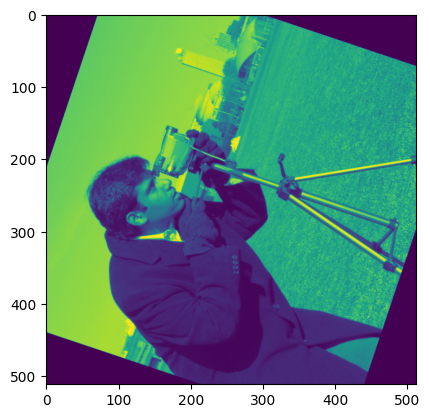

In [14]:
rotated = aligner.forward(camera)
plt.imshow(rotated.detach().cpu().squeeze().numpy())

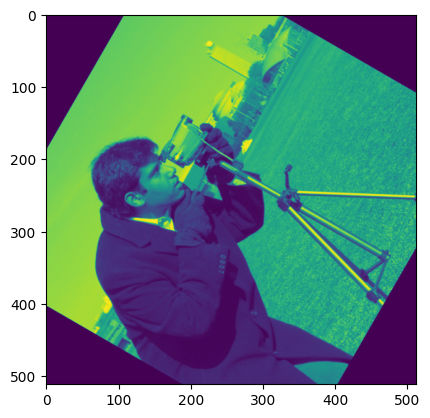

In [15]:
plt.imshow(transformed.detach().cpu().squeeze().numpy())

In [16]:
loss=normalized_mutual_information_loss(rotated.flatten(),transformed.flatten(),num_bins=100,window_radius=5)
loss.backward()

In [17]:
aligner.angle.grad

tensor(0.2043)

In [19]:
rotated=aligner.forward(camera)
loss=mutual_information_loss(rotated.flatten(),transformed.flatten(),num_bins=100,window_radius=5)
loss.backward()
aligner.angle.grad

/home/gael.cousin/Documents/my_code/kornia/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5167: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/gael.cousin/Documents/my_code/kornia/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5100: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(1.6602)